In [1]:
import os
import tarfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# scikit learn
from sklearn.metrics import accuracy_score

# ml models
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
print("Step 1: Setting up configuration...")

CUB_TGZ_PATH = '/content/drive/MyDrive/dataset ML/CUB_200_2011.tgz'

from google.colab import drive
drive.mount('/content/drive')
print(f"Extracting dataset from {CUB_TGZ_PATH}...")
with tarfile.open(CUB_TGZ_PATH, "r:gz") as tar_ref:
    tar_ref.extractall(path='/content')

CUB_DIR = '/content/CUB_200_2011/'
IMAGE_DIR = os.path.join(CUB_DIR, 'images')
print(f"Dataset extracted. Main directory set to: {CUB_DIR}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS_CNN = 10
RANDOM_STATE = 42

Step 1: Setting up configuration...
Mounted at /content/drive
Extracting dataset from /content/drive/MyDrive/dataset ML/CUB_200_2011.tgz...


/tmp/ipython-input-316555349.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall(path='/content')


Dataset extracted. Main directory set to: /content/CUB_200_2011/
Using device: cuda


Data Preparation

In [3]:
print("\n Step 2: Preparing data using official dataset files...")

images_df = pd.read_csv(os.path.join(CUB_DIR, 'images.txt'), sep=' ', names=['img_id', 'filepath'])
labels_df = pd.read_csv(os.path.join(CUB_DIR, 'image_class_labels.txt'), sep=' ', names=['img_id', 'class_id'])
split_df = pd.read_csv(os.path.join(CUB_DIR, 'train_test_split.txt'), sep=' ', names=['img_id', 'is_training_img'])

data_df = images_df.merge(labels_df, on='img_id').merge(split_df, on='img_id')
data_df['class_id'] = data_df['class_id'] - 1

train_df = data_df[data_df['is_training_img'] == 1]
test_df = data_df[data_df['is_training_img'] == 0]

X_train_paths = [os.path.join(IMAGE_DIR, fp) for fp in train_df['filepath']]
X_test_paths = [os.path.join(IMAGE_DIR, fp) for fp in test_df['filepath']]
y_train = train_df['class_id'].values
y_test = test_df['class_id'].values

num_classes = len(data_df['class_id'].unique())
print(f"Found {len(data_df)} total images belonging to {num_classes} classes.")
print(f"Using official split: {len(X_train_paths)} training samples, {len(X_test_paths)} testing samples.")

class BirdDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}




 Step 2: Preparing data using official dataset files...
Found 11788 total images belonging to 200 classes.
Using official split: 5994 training samples, 5794 testing samples.


Feature Extraction

In [4]:
feature_extractor = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(DEVICE)
feature_extractor.eval()

def extract_features(dataset_paths, transform):
    dataset = BirdDataset(dataset_paths, labels=np.zeros(len(dataset_paths)), transform=transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    all_features = []
    with torch.no_grad():
        for inputs, _ in tqdm(loader, desc="Extracting Features"):
            inputs = inputs.to(DEVICE)
            features = feature_extractor(inputs)
            all_features.append(features.cpu().numpy())
    return np.concatenate(all_features)

X_train_features = extract_features(X_train_paths, data_transforms['test'])
X_test_features = extract_features(X_test_paths, data_transforms['test'])

print(f"Shape of training features: {X_train_features.shape}")
print(f"Shape of testing features: {X_test_features.shape}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 117MB/s]
Extracting Features: 100%|██████████| 182/182 [00:51<00:00,  3.56it/s]

Shape of training features: (5994, 2048)
Shape of testing features: (5794, 2048)


7 model implementation

In [5]:
models_to_train = {
    "1. Naive Bayes": GaussianNB(),
    "2. K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5),
    "3. Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "4. Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    "5. Linear Discriminant Analysis (LDA)": LinearDiscriminantAnalysis(),
    "6. Support Vector Machine (SVM)": SVC(kernel='rbf', random_state=RANDOM_STATE),
    "7. Logistic Regression (One-vs-Rest)": LogisticRegression(multi_class='ovr', solver='liblinear', random_state=RANDOM_STATE, max_iter=1000)
}
results = {}

for name, model in models_to_train.items():
    print(f"--- Training {name} ---")
    model.fit(X_train_features, y_train)
    y_pred = model.predict(X_test_features)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"Testing Accuracy for {name}: {accuracy:.4f}")



--- Training 1. Naive Bayes ---
Testing Accuracy for 1. Naive Bayes: 0.6151
--- Training 2. K-Nearest Neighbors (KNN) ---
Testing Accuracy for 2. K-Nearest Neighbors (KNN): 0.4922
--- Training 3. Decision Tree ---
Testing Accuracy for 3. Decision Tree: 0.1961
--- Training 4. Random Forest ---
Testing Accuracy for 4. Random Forest: 0.5204
--- Training 5. Linear Discriminant Analysis (LDA) ---
Testing Accuracy for 5. Linear Discriminant Analysis (LDA): 0.6969
--- Training 6. Support Vector Machine (SVM) ---
Testing Accuracy for 6. Support Vector Machine (SVM): 0.6628
--- Training 7. Logistic Regression (One-vs-Rest) ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Testing Accuracy for 7. Logistic Regression (One-vs-Rest): 0.6631


In [6]:
cnn_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
num_ftrs = cnn_model.classifier[1].in_features
cnn_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
cnn_model = cnn_model.to(DEVICE)

optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_dataset = BirdDataset(X_train_paths, y_train, transform=data_transforms['train'])
test_dataset = BirdDataset(X_test_paths, y_test, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

NUM_EPOCHS_CNN = 12

for epoch in range(NUM_EPOCHS_CNN):
    cnn_model.train() # training mode
    running_loss = 0.0

    for inputs, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_CNN}"):
        inputs, labels_batch = inputs.to(DEVICE), labels_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

print("\nTraining complete.")

print("Evaluating the final model on the test set...")
cnn_model.eval() # evaluation mode
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels_batch in tqdm(test_loader, desc="Testing Phase"):
        inputs, labels_batch = inputs.to(DEVICE), labels_batch.to(DEVICE)
        outputs = cnn_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

cnn_accuracy = accuracy_score(all_labels, all_preds)

results["8. Simplified CNN (EfficientNet)"] = cnn_accuracy
print(f"Final Testing Accuracy for Simplified CNN: {cnn_accuracy:.4f}")


✅ Step 5 (Simplified): Training and Evaluating the CNN...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 168MB/s]
Epoch 1/12: 100%|██████████| 188/188 [01:00<00:00,  3.13it/s]


Epoch 1 Loss: 5.0617


Epoch 2/12: 100%|██████████| 188/188 [00:59<00:00,  3.17it/s]


Epoch 2 Loss: 3.8734


Epoch 3/12: 100%|██████████| 188/188 [00:58<00:00,  3.21it/s]


Epoch 3 Loss: 2.9134


Epoch 4/12: 100%|██████████| 188/188 [00:59<00:00,  3.17it/s]


Epoch 4 Loss: 2.3228


Epoch 5/12: 100%|██████████| 188/188 [00:59<00:00,  3.16it/s]


Epoch 5 Loss: 1.9330


Epoch 6/12: 100%|██████████| 188/188 [00:58<00:00,  3.21it/s]


Epoch 6 Loss: 1.6985


Epoch 7/12: 100%|██████████| 188/188 [00:59<00:00,  3.17it/s]


Epoch 7 Loss: 1.4614


Epoch 8/12: 100%|██████████| 188/188 [00:58<00:00,  3.21it/s]


Epoch 8 Loss: 1.3417


Epoch 9/12: 100%|██████████| 188/188 [00:58<00:00,  3.20it/s]


Epoch 9 Loss: 1.2175


Epoch 10/12: 100%|██████████| 188/188 [00:58<00:00,  3.20it/s]


Epoch 10 Loss: 1.1310


Epoch 11/12: 100%|██████████| 188/188 [00:58<00:00,  3.20it/s]


Epoch 11 Loss: 1.0523


Epoch 12/12: 100%|██████████| 188/188 [00:58<00:00,  3.23it/s]


Epoch 12 Loss: 0.9923

Training complete.
Evaluating the final model on the test set...


Testing Phase: 100%|██████████| 182/182 [00:43<00:00,  4.14it/s]

Final Testing Accuracy for Simplified CNN: 0.7891




      FINAL MODEL ACCURACIES      

                                Model  Testing Accuracy
     8. Simplified CNN (EfficientNet)          0.789092
5. Linear Discriminant Analysis (LDA)          0.696928
 7. Logistic Regression (One-vs-Rest)          0.663100
      6. Support Vector Machine (SVM)          0.662755
                       1. Naive Bayes          0.615119
                     4. Random Forest          0.520366
         2. K-Nearest Neighbors (KNN)          0.492233
                     3. Decision Tree          0.196065


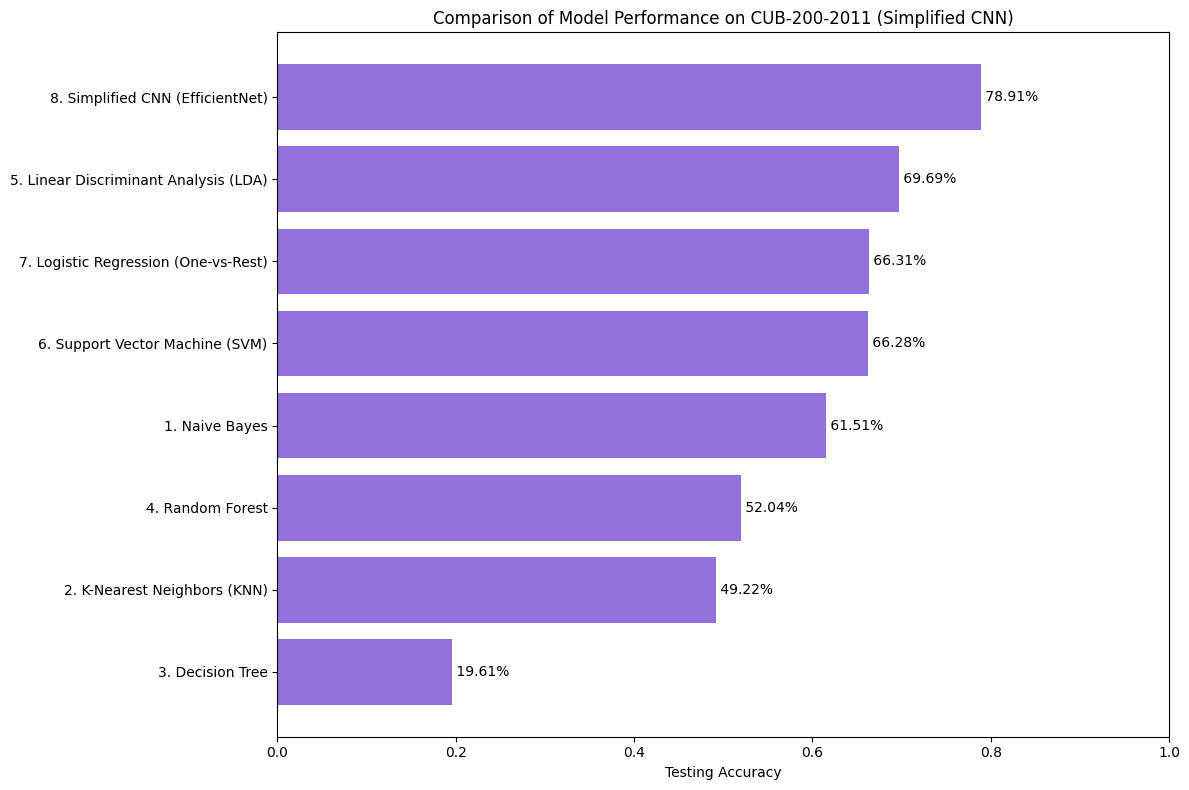

In [7]:
print("\n\n====================================")
print("      FINAL MODEL ACCURACIES      ")
print("====================================\n")

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Testing Accuracy'])
results_df = results_df.sort_values(by='Testing Accuracy', ascending=False)
print(results_df.to_string(index=False))

plt.figure(figsize=(12, 8))
bars = plt.barh(results_df['Model'], results_df['Testing Accuracy'], color='mediumpurple')
plt.xlabel('Testing Accuracy')
plt.title('Comparison of Model Performance on CUB-200-2011 (Simplified CNN)')
plt.xlim(0, 1)
plt.gca().invert_yaxis()
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f' {bar.get_width():.2%}', va='center', ha='left')
plt.tight_layout()
plt.show()